In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import numpy as np
import scipy
import pandas as pd
from PIL import Image
import xml.etree.ElementTree as ET
%matplotlib inline

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
import tensorflow.keras.utils
from sklearn.model_selection import train_test_split

### Loading Data

In [2]:
absFolder=os.getcwd()
parentFolder = os.path.dirname(absFolder)
dataFolder = os.path.join(parentFolder, 'Data')
allImagesFolder = os.path.join(dataFolder, 'all')

In [3]:
labels = []

for filename in os.listdir(allImagesFolder):
    if filename.endswith(".xml"):
        filepath = os.path.join(allImagesFolder, filename)
        xml = ET.parse(filepath)
        annot = xml.getroot()
        fName = annot.find('filename').text
        size = annot.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)
        if width<40 or height<40 or width >999999 or height> 999999:
            continue
        
        objects = annot.findall('object')
        if len(objects)!=1:
            pass
        elif objects[0].find('name').text=='pothole':
            box = objects[0].find('bndbox')
            
            xmin = int(box.find("xmin").text)
            ymin = int(box.find("ymin").text)
            xmax = int(box.find("xmax").text)
            ymax = int(box.find("ymax").text)
            
            if xmin<0 or xmax>width or ymin<0 or ymax>height:
                continue
            
            labels.append([fName, width, height, "pothole", xmin, ymin, xmax, ymax])

labelDf = pd.DataFrame(labels, 
                       columns=["filename", "width", 'height', "class", 'xmin', 'ymin', 'xmax', 'ymax'])


In [4]:
labelDf.describe()

,width,height,xmin,ymin,xmax,ymax
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,1316.570652,785.668478,399.866848,292.739130,910.690217,519.584239
std,669.241859,365.140612,311.701459,170.988813,446.511805,237.165088
min,200.000000,129.000000,1.000000,12.000000,116.000000,77.000000
25%,658.500000,441.000000,114.750000,162.000000,534.000000,348.000000
50%,1333.500000,929.500000,299.500000,312.000000,859.000000,552.000000
75%,1920.000000,1080.000000,720.250000,402.250000,1320.500000,658.000000
max,4032.000000,3024.000000,1328.000000,1611.000000,2309.000000,2211.000000


In [5]:
labelDf.isnull().sum()

filename    0
width       0
height      0
class       0
xmin        0
ymin        0
xmax        0
ymax        0
dtype: int64

In [6]:
newSize = (128, 128)

labelDf.xmin = labelDf.xmin/labelDf.width
labelDf.xmax = labelDf.xmax/labelDf.width
labelDf.ymin = labelDf.ymin/labelDf.height
labelDf.ymax = labelDf.ymax/labelDf.height

In [8]:
labelDf.tail()

,filename,width,height,class,xmin,ymin,xmax,ymax
363,pothole0161.jpg,1920,1080,pothole,0.347396,0.369444,0.671354,0.625926
364,pothole0162.jpg,1920,1080,pothole,0.315625,0.386111,0.678125,0.635185
365,pothole0163.jpg,1920,1080,pothole,0.314063,0.387037,0.656250,0.610185
366,pothole0164.jpg,1920,1080,pothole,0.319792,0.385185,0.651563,0.619444
367,pothole0165.jpg,1920,1080,pothole,0.300000,0.373148,0.640104,0.627778


In [9]:
labelDf['w'] = labelDf.xmax - labelDf.xmin
labelDf['h'] = labelDf.ymax - labelDf.ymin

In [10]:
def retrieveImage(fName):
    fPath = os.path.join(allImagesFolder, fName)
    pic = np.asarray(Image.open(fPath).convert('RGB').resize(newSize)) / 255.0
    return pic

In [11]:
X = np.array(labelDf.filename.apply(retrieveImage).tolist())



In [12]:
Y = labelDf[['xmin', 'ymin', 'w', 'h']].to_numpy()
Y.shape

(368, 4)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=41)

In [14]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(294, 128, 128, 3)
(294, 4)
(74, 128, 128, 3)
(74, 4)


### Data Augmentation

In [45]:
max_brightness_factor = 0.2
max_rotation_angle = 60

class PotholeBatchGenerator(tensorflow.keras.utils.Sequence):
    def __init__(self, 
                x_set,
                y_set,
                batch_size,
                image_dims=newSize,
                 shuffle=True,
                 num_channels=3,
                 num_outputs=4,
                 is_train=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dims = image_dims
        self.shuffle=shuffle
        self.num_channels = num_channels
        self.num_outputs = num_outputs
        self.num_images = self.x.shape[0]
        self.indexes = np.arange(self.num_images)
        self.is_train = is_train
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __len__(self):
        return int(np.floor(self.num_images / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(self.num_images)
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dims, self.num_channels))
        y = np.empty((self.batch_size, self.num_outputs))
        
        for i in range(self.batch_size):
            flip_flag = np.random.randint(2)
            if flip_flag ==1 and self.is_train:
                x[i, :, :, :] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
            else:
                x[i, :, :, :] = self.x[batch_indexes[i],:,:,:]
                
            y[i,:] = self.y[batch_indexes[i],:]
            
            if self.is_train:
                brightness_mult = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i,:,:,:] = brightness_mult * x[i,:,:,:]
                
        if self.is_train:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        else:
            angle = 0
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
        
        return x_rot, y

(16, 128, 128, 3)


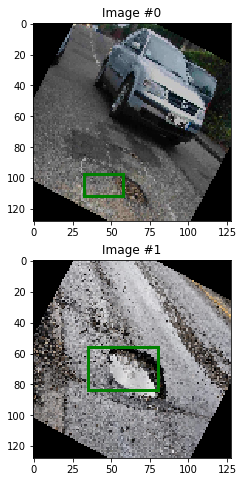

In [70]:
# looking at batch generator

batch_size = 16
num_show=2

gen = PotholeBatchGenerator(X, Y, batch_size, shuffle=False, is_train=True)

bx, by = gen.__getitem__(0)
print(bx.shape)

i = np.random.randint(batch_size)

fig = plt.figure(figsize=(18,4*num_show))
for i in range(num_show):
    
    [x,y,w,h] = by[i,:]
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]
    
    
    a1 = fig.add_subplot(num_show, 3, i*3+1)
    img1 = a1.imshow(bx[i,:,:,:])
    a1.set_title("Image #{}".format(i))
    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    a1.add_patch(rect)


### Model design

In [59]:
model = Sequential()
model.add(Conv2D(16, (2,2), input_shape=(newSize[0],newSize[1], 3), activation='relu'))
# model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, (2,2), activation='relu'))
# model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(64, (2,2), activation='relu'))
# # model.add(Conv2D(64, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(128, (2,2), activation='relu'))
# model.add(Conv2D(128, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

# model.add(Conv2D(256, (2,2), activation='relu'))
# model.add(Conv2D(256, (3,3), activation='relu'))
# model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(4))
model.add(Activation('linear'))



In [60]:
model.compile(optimizer= 'adam', loss='mean_absolute_error')

In [61]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs=20)

Train on 294 samples, validate on 74 samples
Epoch 1/20
294/294 [==============================] - 1s 4ms/sample - loss: 0.8639 - val_loss: 0.4675
Epoch 2/20
294/294 [==============================] - 0s 949us/sample - loss: 0.2701 - val_loss: 0.1747
Epoch 3/20
294/294 [==============================] - 0s 928us/sample - loss: 0.1478 - val_loss: 0.1165
Epoch 4/20
294/294 [==============================] - 0s 912us/sample - loss: 0.1191 - val_loss: 0.1168
Epoch 5/20
294/294 [==============================] - 0s 908us/sample - loss: 0.1027 - val_loss: 0.1096
Epoch 6/20
294/294 [==============================] - 0s 905us/sample - loss: 0.0878 - val_loss: 0.0931
Epoch 7/20
294/294 [==============================] - 0s 915us/sample - loss: 0.0706 - val_loss: 0.0965
Epoch 8/20
294/294 [==============================] - 0s 905us/sample - loss: 0.0602 - val_loss: 0.0883
Epoch 9/20
294/294 [==============================] - 0s 912us/sample - loss: 0.0526 - val_loss: 0.0920
Epoch 10/20
294/294 [

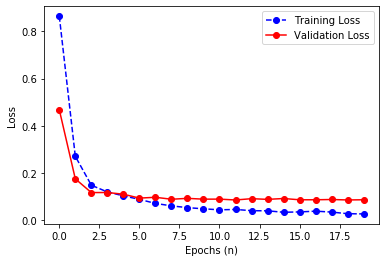

In [62]:
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'] ,'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

(78.88, 74.21224212646484)
(23.466666666666665, 30.138683319091797)
(41.28, 50.27631378173828)
(25.813333333333336, 35.11024475097656)


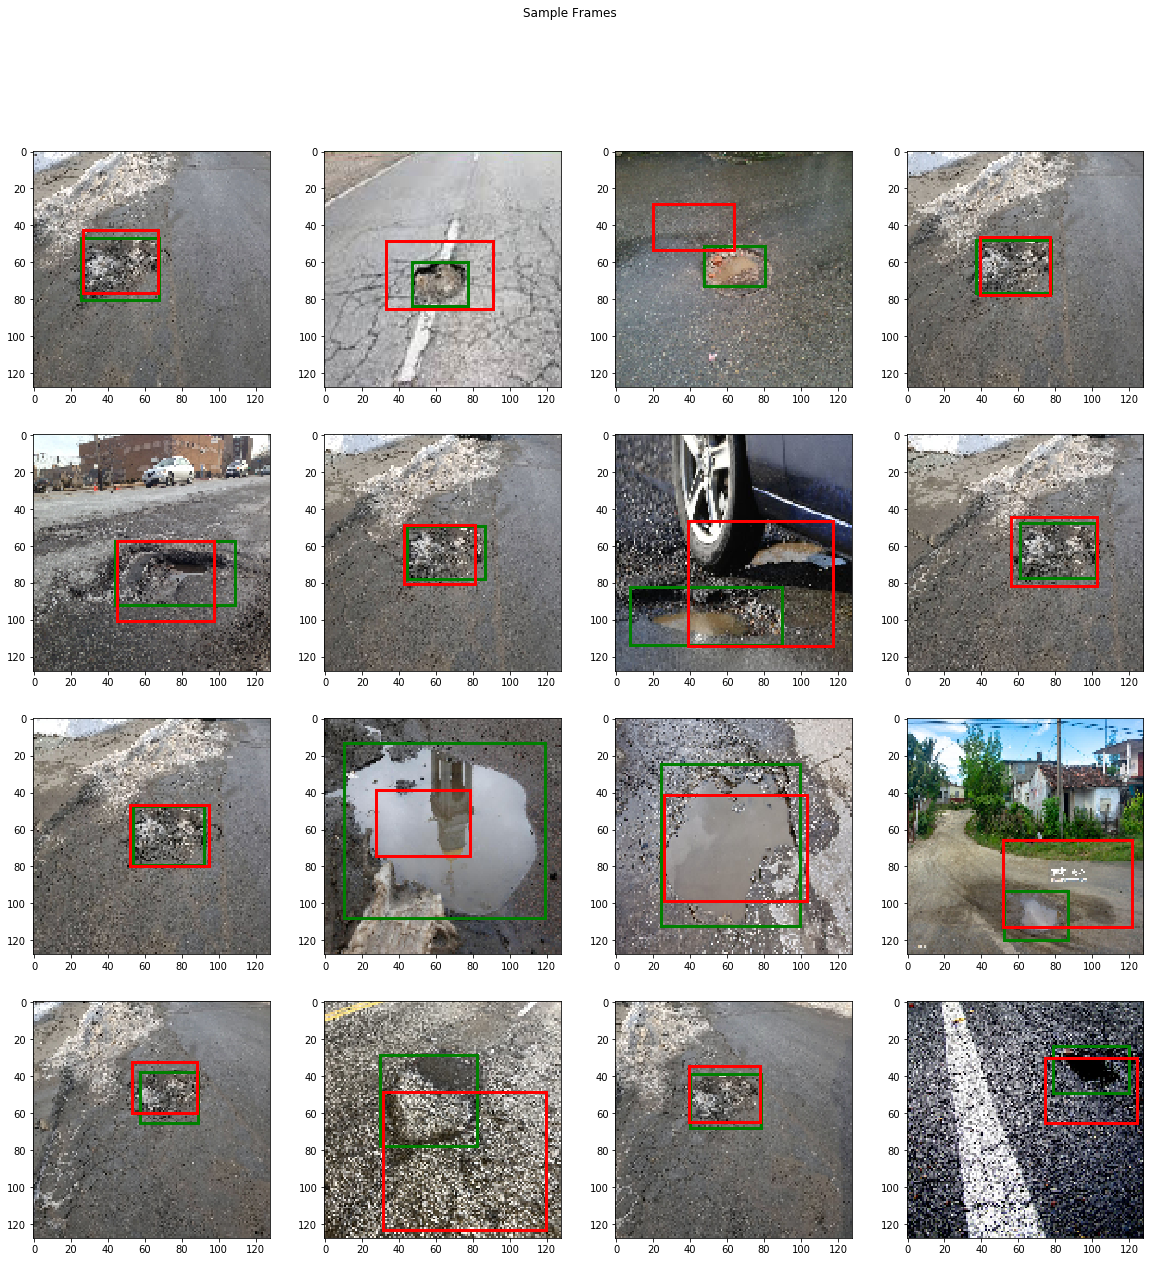

In [63]:
shift = 4
sampleNum = 16
fig, axs = plt.subplots(sampleNum//4, 4, figsize=(20,20))
fig.suptitle("Sample Frames")

for imgNum in range(sampleNum):
    plt.imshow(X_test[imgNum])
    axs[imgNum//4][imgNum%4].imshow(X_test[20+imgNum + shift])
    
    
    [x,y,w,h] = Y_test[20+imgNum + shift]
    [[x1,y1,w1,h1]] = model.predict(np.expand_dims(X_test[20+imgNum + shift], axis=0))
    
    x = x*newSize[0]
    y = y*newSize[1]
    w = w*newSize[0]
    h = h*newSize[1]

    x1= x1*newSize[0]
    y1= y1*newSize[1]
    w1= w1*newSize[0]
    h1= h1*newSize[1]

    rect = pat.Rectangle((x,y),w,h, linewidth = 3, edgecolor='g', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect)
    rect1 = pat.Rectangle((x1,y1),w1,h1, linewidth = 3, edgecolor='r', facecolor='none')
    axs[imgNum//4][imgNum%4].add_patch(rect1)
print((x,x1))
print((y,y1))
print((w,w1))
print((h,h1))